In [ ]:
!pip install imutils   #A package of fns to make basic image processing functions such as translation, rotation, resizing, skeletonization, displaying Matplotlib images, sorting contours, etc

In [ ]:
!pip install py-sudoku  #generates and solves sudoku puzzles

In [10]:
import cv2
import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from tensorflow.keras.models import load_model
import numpy as np
from sudoku import Sudoku
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import glob
import os
#import necessary libraries

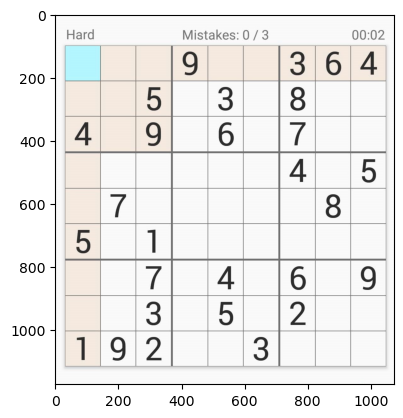

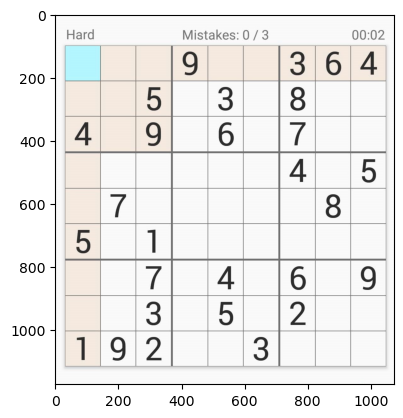

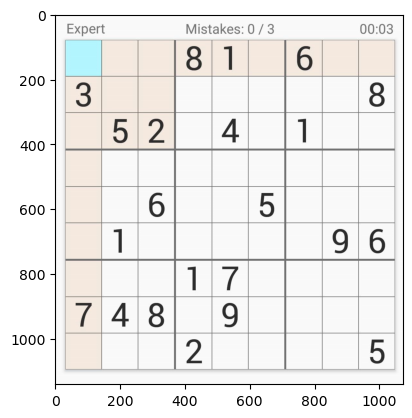

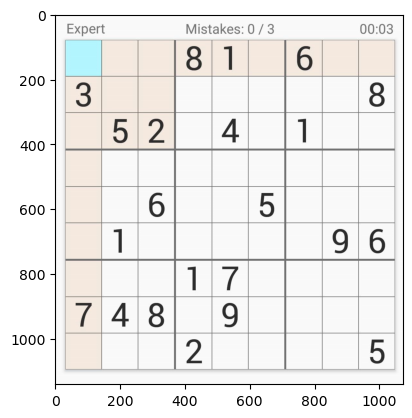

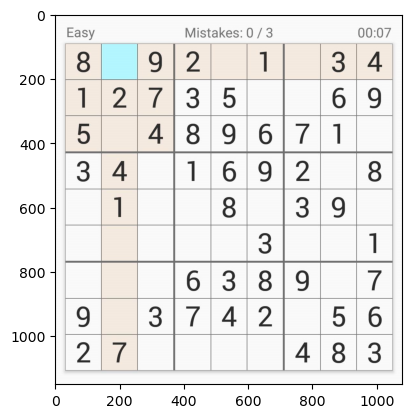

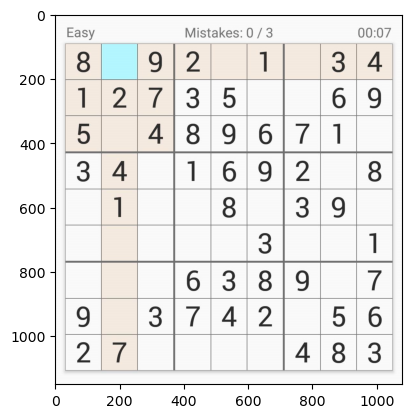

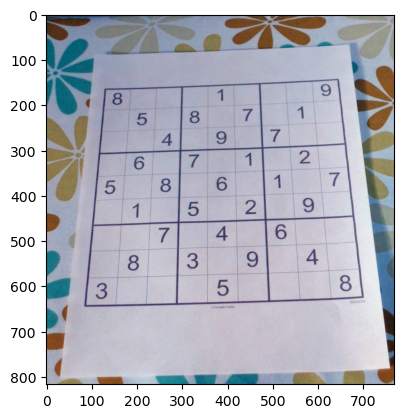

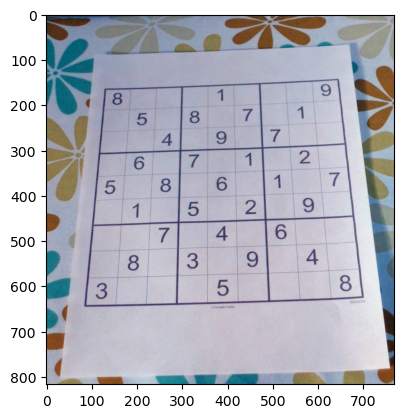

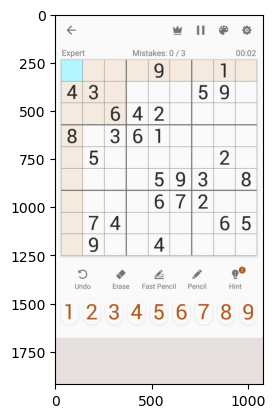

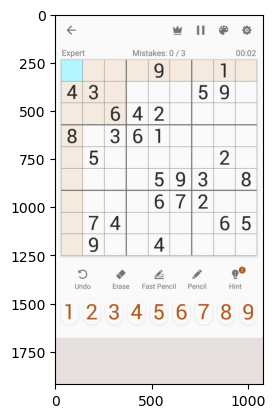

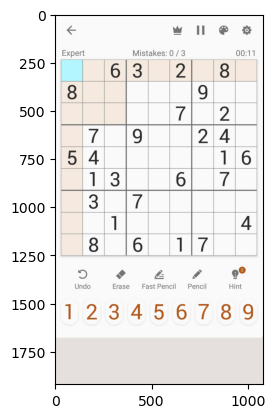

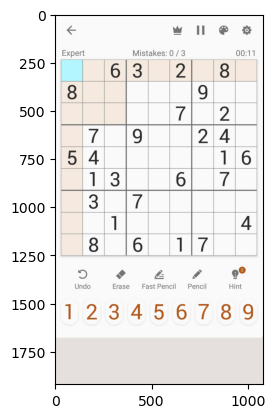

In [11]:
img_dir = "sudoku images"
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 
data = [] 
for f1 in files: 
    img = cv2.imread(f1) 
    data.append(img) 
    plt.figure() 
    plt.imshow(img) 
    ratio = img.shape[0] / img.shape[1]
    img = cv2.resize(img, (1100, int(1100 * ratio)))


In [12]:

# Sudoku Solver
model = load_model('model/model_mnist/')  #load MNIST data(MNISt database consists of handwritten digits used for training images in processing systems) and sudoku image
img_path = 'sudoku images/6.png'
img_shape = [28,28]

def find_puzzle(img):
    real = img.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),1)
    
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    thresh = cv2.bitwise_not(thresh)

    cnts = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts,key=cv2.contourArea,reverse=True)

    puzzle_cnt = None

    for c in cnts:
        peri = cv2.arcLength(c,True)  #contour perimeter 
        approx = cv2.approxPolyDP(c,0.02*peri,True)  #reduces polygonal vertices by approxmtng with a different polygon at specified precision, given a threshold(min) value
        if len(approx)==4:
            puzzle_cnt=approx
            break

    if puzzle_cnt is None:
        raise Exception(("Could not find Sudoku puzzle outline.Try debugging your thresholding and contour steps."))

    cv2.drawContours(real, [puzzle_cnt], -1, (0, 255, 0), 2)

    puzzle = four_point_transform(img, puzzle_cnt.reshape(4, 2))
    warped = four_point_transform(gray, puzzle_cnt.reshape(4, 2))

    return puzzle,warped

#Overall,this function finds the puzzle in the image through image processing techniques.
#Reads the image, convert it to grayscale, apply 'Gaussian blur' to reduce/noise.
#Image thresholding is a simple, yet effective, way of partitioning an image into a foreground and background. 
#This image analysis technique is a type of image segmentation that isolates objects by converting grayscale images into binary images(white to black, black to white)
#Finds the contour & extrtact the biggest contour in the image, which is the sudoku.
#Apply 4 point transformation to get a straight view/ bird's eye view of the puzzle and return it. "warped" = summarized/shortened/distorted


In [13]:
#Function to extract the digit cell from the puzzle and return it so that the mnist model could identify the number in it.
def extract_digit(cell):
    thresh = cv2.threshold(cell,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh) #just clear the extra white pixels along the border


    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # if no contours were found then this is an empty cell
    if len(cnts) == 0:return None

    # otherwise, find the largest contour in the cell and create a mask for the contour
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)

    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)

    # if less than 3% of the mask is filled then we are looking at noise and can safely ignore the contour
    if percentFilled < 0.03:return None

    # apply the mask to the thresholded cell
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    kernel = np.ones((1,1),np.uint8)
    digit = cv2.dilate(digit,kernel,iterations=1)

    # return the digit to the calling function
    return digit




In [15]:
#This function simply puts the numbers on the image/board.
def display_numbers_on_board(board,puzzle):
    x = puzzle.copy()
    k = 0
    for i in range(9):
        for j in range(9):
            startX,startY,endX,endY = cell_locs[k]
            testX = int((endX - startX) * 0.33)
            testY = int((endY - startY) * -0.2)
            testX += startX
            testY += endY
            cv2.putText(x,str(board[i][j]),(testX,testY),cv2.FONT_HERSHEY_SIMPLEX,0.9,(0,0,255),2)
            k+=1
    plt.figure(figsize=(10,8))
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return x

#Is cell_locs[k] valid here... aaagghhh?!? 

In [16]:
img = cv2.imread(img_path)
img = imutils.resize(img,width=600)
#Reads and resize the image

puzzle,warped = find_puzzle(img)
puzzle = imutils.resize(puzzle,width=600)
warped = imutils.resize(warped,width=600)

#Extract puzzle and resize it appropriately

In [17]:
step_x = warped.shape[1]//9
step_y = warped.shape[0]//9

#specifies step size in x and y directions. Now, distance in feet/number of steps = step length. something similar.
#Here, this step is basically the cell size in the x and y directions.

board = np.zeros(shape=(9,9),dtype='int')  #Create the board with all values initialized with 0s.
cell_locs = []  #Create array cell_locs which will contain the cell locations/coordinates.



In [18]:
for i in range(9):
    for j in range(9):
        topleftx = j*step_x
        toplefty = i*step_y
        rightendx= (j+1)*step_x
        rightendy = (i+1)*step_y
        cell = warped[toplefty:rightendy, topleftx:rightendx]
        digit = extract_digit(cell)
        if digit is not None:
            roi = cv2.resize(digit,tuple(img_shape))
            roi = roi.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)
            pred = model.predict(roi).argmax(axis=1)[0]
            board[i,j] = pred
        cell_locs.append([topleftx,toplefty,rightendx,rightendy])
#Traverse in the 9*9 loop where the first 9 represents the 9 rows of the board and the second 9 represents the 9 columns of the board. 
#On traversing it will extract the cell images, predict the number using mnist and put that number in the "board" array created earlier. 
#Also, we will keep on storing the cell locations in the "cell_loc" array.
        


1/1 [==============================] - 0s 63ms/step


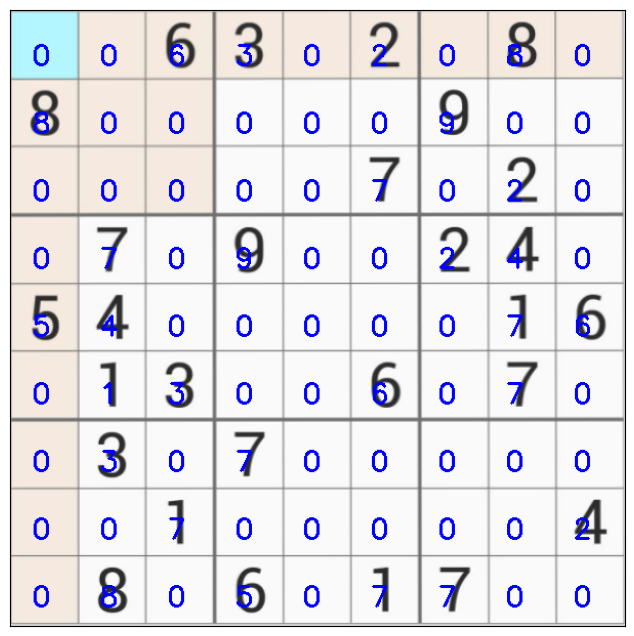

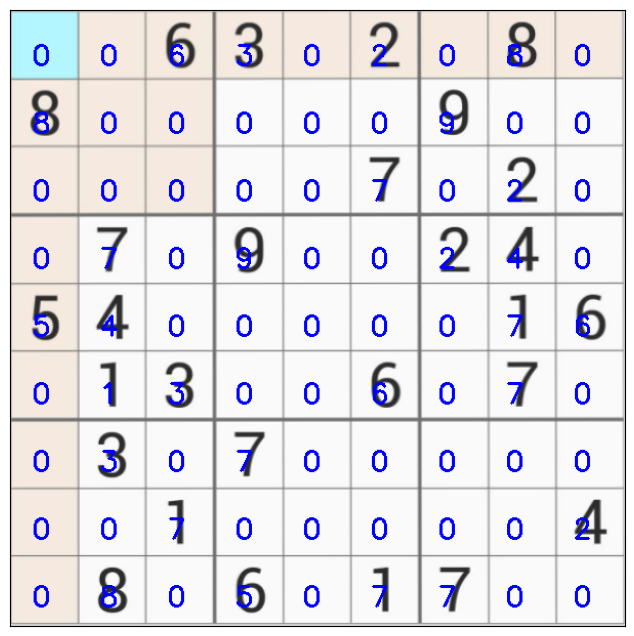

Are all numbers predicted correctly? (y/n)n
Input row no, col no, correct element of cell For eg. --> 1 2 1:  4 7 1


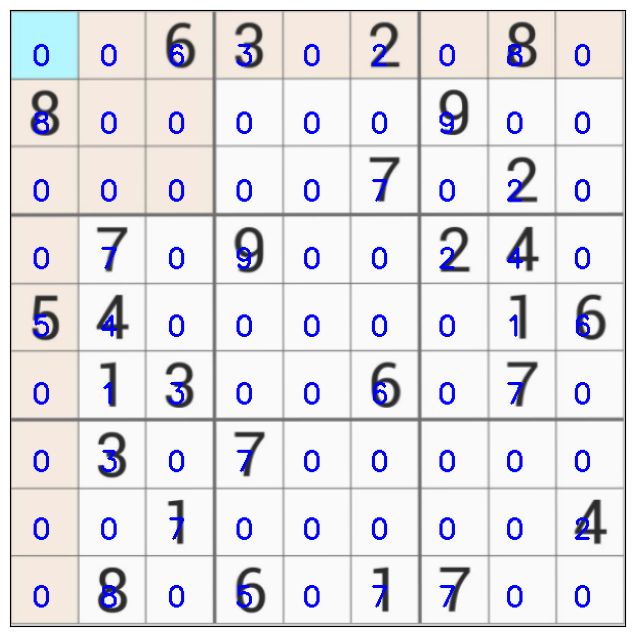

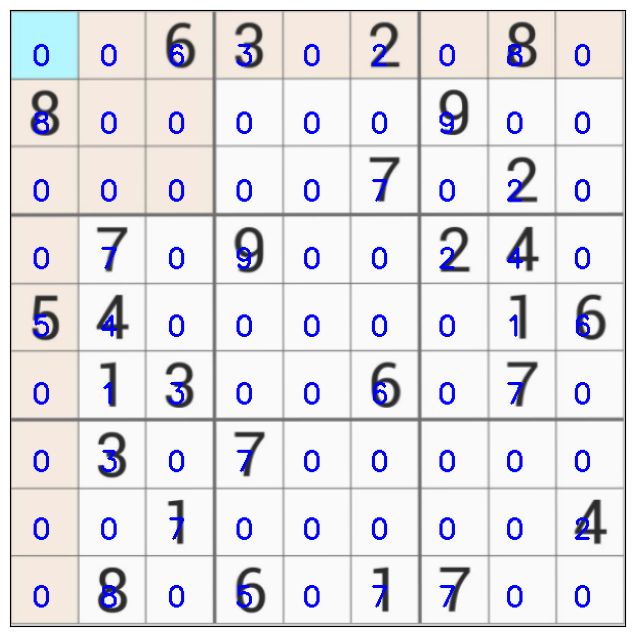

In [ ]:
#Now, if by chance any of the numbers is wrongly predicted by the mnist, correct it. P.S. As of 24 May, this code is inefficient.
#Debugging, remains...

_=display_numbers_on_board(board,puzzle)

while 1:
    res = input('Are all numbers predicted correctly? (y/n)')
    if res=='n':
        cx,cy,ele = input('Input row no, col no, correct element of cell For eg. --> 1 2 1:  ').split()
        try:
            board[int(cx),int(cy)] = int(ele)
        except:
            print('out of range...')
        _ = display_numbers_on_board(board,puzzle)
    elif res=='y':
        break
    else:
        print('Wrong choice!!!')
#The numbers in blue are predicted numbers for that cell. The text in red is the address of that cell(which is apparently missing at the moment). 
#If any number is wrongly classified by mnist, correct that. 
#Like the first wrong classified number is at (4,7). The original number there is 1 but the mnist said it is 7 so we will correct it first.
solved = solveSudoku(board)
x = display_numbers_on_board(board,puzzle)
cv2.imshow('solved',x)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#To be continued...